In [1]:
# # Google Colab specific code for mounting Google Drive
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

# # Define the directory path on your Google Drive
# # Replace 'Your_directory' with the actual directory
# directory = '/content/drive/My Drive/Colab Notebooks/ML4GST/'

# # Now use this directory for reading and writing data
# data_template_filename = directory + "dataset.txt"
# gst_dir = directory + "test_gst_dir"

In [2]:
import os

In [3]:
# Change the working directory to the desired path
os.chdir(r"C:\Users\ALAN\Documents\ML4GST")

# Verify that the working directory has been changed
print("Current working directory:", os.getcwd())


Current working directory: C:\Users\ALAN\Documents\ML4GST


In [4]:
# pip install pygsti

In [5]:
# import pygsti
# import pygsti.algorithms.fiducialselection as fidsel
# import pygsti.algorithms.germselection as germsel
# import numpy as np
# import pandas as pd

# # Define the Pauli Transfer Matrices for the gates
# # I = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])
# # X_pi_4 = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, np.cos(np.pi/4), -np.sin(np.pi/4)], [0, 0, np.sin(np.pi/4), np.cos(np.pi/4)]])
# # Y_pi_2 = np.array([[1, 0, 0, 0], [0, np.cos(np.pi/2), 0, np.sin(np.pi/2)], [0, 0, 1, 0], [0, -np.sin(np.pi/2), 0, np.cos(np.pi/2)]])

# # Create the explicit model
# ideal_target_model = pygsti.models.create_explicit_model_from_expressions(
#     [('Q0',)], ['Gi', 'Gx', 'Gy'],
#     ["I(Q0)", "X(pi/4,Q0)", "Y(pi/2,Q0)"])

# class MyXPi2Operator(pygsti.modelmembers.operations.DenseOperator):
#     def __init__(self):
#         #initialize with no noise
#         super(MyXPi2Operator,self).__init__(np.identity(4,'d'), 'pp', "densitymx") # this is *super*-operator, so "densitymx"
#         self.from_vector([0.0, 0.1])

#     @property
#     def num_params(self):
#         return 2 # we have two parameters

#     def to_vector(self):
#         return np.array([self.depol_amt, self.over_rotation],'d') #our parameter vector

#     def from_vector(self, v, close=False, dirty_value=True):
#         #initialize from parameter vector v
#         self.depol_amt = v[0]
#         self.over_rotation = v[1]

#         # print(f'depol_amt: {self.depol_amt}, over_rotation: {self.over_rotation}')

#         theta = (np.pi/4 + self.over_rotation)/2
#         a = 1.0-self.depol_amt
#         b = a*2*np.cos(theta)*np.sin(theta)
#         c = a*(np.sin(theta)**2 - np.cos(theta)**2)

#         # print(f'a: {a}, b: {b}, c: {c}')

#         # ._ptr is a member of DenseOperator and is a numpy array that is
#         # the dense Pauli transfer matrix of this operator
#         # Technical note: use [:,:] instead of direct assignment so id of self._ptr doesn't change
#         self._ptr[:,:] = np.array([[1,   0,   0,   0],
#                                   [0,   a,   0,   0],
#                                   [0,   0,   c,  -b],
#                                   [0,   0,   b,   c]],'d')
#         self.dirty = dirty_value  # mark that parameter vector may have changed

#     def transform(self, S):
#         # Update self with inverse(S) * self * S (used in gauge optimization)
#         raise NotImplementedError("MyXPi2Operator cannot be transformed!")

# import copy
# target_model = copy.deepcopy(ideal_target_model)
# target_model.operations[('Gx')] = MyXPi2Operator()
# print('target_model: \n', target_model)
# print('ideal_target_model: \n', ideal_target_model)



In [6]:
# # Automatic selection of fiducials and germs using "laissez-faire" method
# prepFiducials, measFiducials = fidsel.find_fiducials(ideal_target_model)
# germs = germsel.find_germs(ideal_target_model, seed = 1234)

In [7]:
# print(f'prepFiducials: {prepFiducials} \n measFiducials: {measFiducials} \n germs: {germs}')

In [8]:
# # Generate a list of circuits using the long-sequence gate set tomography (LSGST) method
# maxLengths = [2**n for n in range(5)]

# listOfExperiments = pygsti.circuits.create_lsgst_circuits(
#     target_model, prepFiducials, measFiducials, germs, maxLengths)

# # Simulate the probability outcomes of these circuits
# ds = pygsti.data.simulate_data(target_model, listOfExperiments, num_samples=1000,
#                                             sample_error="binomial", seed=1234)
# # print(ds)

# pygsti.io.write_dataset("Custom_1Q_XYI_dataset_abc.txt", ds, outcome_label_order=['0','1'])

# # Convert the probabilities to a DataFrame and save to a CSV file

In [9]:
import math
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Lambda
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
import tensorflow_probability as tfp

# Load the sorted data directly from the modified CSV
df_sorted = pd.read_csv('Sorted_Encoded_Padded_Probabilities.csv')

def prepare_data(df_part):
    # Extracting features and labels
    X = df_part['Padded'].apply(lambda x: [int(xi) for xi in x.strip('[]').split()]).to_list()
    y = df_part[['Prob1', 'Prob2']].values

    # Convert to numpy arrays
    X = np.array(X)
    y = np.array(y)

    return X, y
  
# def map_integers_to_gates(int_sequences, gate_matrices):
#     """
#     Map each integer in the sequences to its corresponding quantum gate matrix.
    
#     Args:
#     - int_sequences (np.array): An array of shape (batch_size, seq_length) containing integer sequences.
#     - gate_matrices (list): A list of 4x4 matrices representing quantum gates.
    
#     Returns:
#     - np.array: An array of shape (batch_size, seq_length, 4, 4) containing the mapped sequences.
#     """
#     # Initialize an empty array to store the mapped sequences
#     mapped_sequences = np.zeros((int_sequences.shape[0], int_sequences.shape[1], 4, 4))
    
#     # Loop through each sequence
#     for i in range(int_sequences.shape[0]):
#         # Find the length of the meaningful part of the sequence (non-zero part)
#         meaningful_length = np.max(np.nonzero(int_sequences[i])) + 1 if np.any(int_sequences[i]) else 0
        
#         # Map the integers to their corresponding quantum gate matrices
#         for j in range(meaningful_length):
#             mapped_sequences[i, j] = gate_matrices[int_sequences[i, j]]
            
#     return mapped_sequences

# # Example usage:
# example_sequences = np.array([[1, 2, 2, 3, 0], [3, 1, 0, 0, 0]])
# I_gate = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])
# X_pi_4_gate = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, np.cos(np.pi/4), -np.sin(np.pi/4)], [0, 0, np.sin(np.pi/4), np.cos(np.pi/4)]])
# Y_pi_2_gate = np.array([[1, 0, 0, 0], [0, np.cos(np.pi/2), 0, np.sin(np.pi/2)], [0, 0, 1, 0], [0, -np.sin(np.pi/2), 0, np.cos(np.pi/2)]])
# gate_matrices = [None, X_pi_4_gate, Y_pi_2_gate, I_gate]  # The "None" entry will be skipped 

In [10]:
def map_integers_to_gates(int_sequences, gate_matrices):
    """
    Map each integer in the sequences to its corresponding quantum gate matrix.
    This version also maps zeros to a 4x4 zero matrix.
    
    Args:
    - int_sequences (np.array): An array of shape (batch_size, seq_length) containing integer sequences.
    - gate_matrices (list): A list of 4x4 matrices representing quantum gates.
    
    Returns:
    - np.array: An array of shape (batch_size, seq_length, 4, 4) containing the mapped sequences.
    """
    # Initialize an empty array to store the mapped sequences
    mapped_sequences = np.zeros((int_sequences.shape[0], int_sequences.shape[1], 4, 4))
    
    # Loop through each sequence
    for i in range(int_sequences.shape[0]):
        # Map the integers to their corresponding quantum gate matrices
        for j in range(int_sequences.shape[1]):
            mapped_sequences[i, j] = gate_matrices[int_sequences[i, j]]
            
    return mapped_sequences

# Example usage:
example_sequences = np.array([[1, 2, 2, 3, 0], [3, 1, 0, 0, 0]])
zero_matrix = np.zeros((4, 4))
I_gate = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])
X_pi_2_gate = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, np.cos(np.pi/2), -np.sin(np.pi/2)], [0, 0, np.sin(np.pi/2), np.cos(np.pi/2)]])
Y_pi_2_gate = np.array([[1, 0, 0, 0], [0, np.cos(np.pi/2), 0, np.sin(np.pi/2)], [0, 0, 1, 0], [0, -np.sin(np.pi/2), 0, np.cos(np.pi/2)]])
gate_matrices = [zero_matrix, X_pi_2_gate, Y_pi_2_gate, I_gate]

# # Run the function
# result = map_integers_to_gates(example_sequences, gate_matrices)
# print("Result shape:", result.shape)


In [11]:
X, y = prepare_data(df_sorted)

print('X type: ', type(X))
print('y type: ', type(y))

# Create new input data
X_new = [X, y]

# # Split the original input (X[0]) and target labels (y) into training and test sets
# X_train_0, X_test_0, y_train, y_test = train_test_split(X_new[0], y, test_size=0.2, random_state=42)

# print('X_train_0 type: ', type(X_train_0))
# print('y_train type: ', type(y_train))

X_train_0 = X
y_train = y 

# Run the mapping function to convert integer sequences to gate matrices
X_train_mapped = map_integers_to_gates(X_train_0, gate_matrices)
# X_test_mapped = map_integers_to_gates(X_test_0, gate_matrices)

# New input data after mapping
X_train = [X_train_mapped, y_train]
# X_test = [X_test_mapped, y_test]

# # Manually combine the split y labels into the X data
# X_train = [np.array(X_train_0), np.array(y_train)]
# X_test = [np.array(X_test_0), np.array(y_test)]

# Convert y data to numpy arrays
# y_train = np.array(y_train)
# y_test = np.array(y_test)



X type:  <class 'numpy.ndarray'>
y type:  <class 'numpy.ndarray'>


In [12]:
len(X_train[0][0])

19

In [13]:
# # @tf.keras.utils.register_keras_serializable()
# class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
#     def __init__(self, d_model, warmup_steps=4000):
#         super(CustomSchedule, self).__init__()

#         self.d_model = tf.cast(d_model, tf.float32)
#         self.warmup_steps = warmup_steps

#     def __call__(self, step):
#         step = tf.cast(step, dtype=tf.float32)
#         arg1 = tf.math.rsqrt(step)
#         arg2 = step * (self.warmup_steps ** -1.5)

#         return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

#     def get_config(self):
#         return {
#             "d_model": float(self.d_model), # Convert to native Python float
#             "warmup_steps": self.warmup_steps
#         }



# @tf.keras.utils.register_keras_serializable()
# class TriangularLearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
#     def __init__(self, min_lr, max_lr, step_size, mode='triangular', gamma=0.99):
#         super(TriangularLearningRateScheduler, self).__init__()
        
#         self.min_lr = min_lr
#         self.max_lr = max_lr
#         self.step_size = step_size
#         self.mode = mode
#         self.gamma = gamma

#     def __call__(self, step):
#         step = tf.cast(step, dtype=tf.float32)
#         cycle = tf.math.floor(1 + step / (2 * self.step_size))
#         x = tf.math.abs(step / self.step_size - 2 * cycle + 1)
#         lr = self.min_lr + (self.max_lr - self.min_lr) * tf.math.maximum(0.0, (1 - x))

#         if self.mode == 'triangular2':
#             lr = lr * (1 / (2 ** (cycle - 1)))
#         elif self.mode == 'exp_range':
#             lr = lr * (self.gamma ** step)

#         return lr

#     def get_config(self):
#         return {
#             "min_lr": self.min_lr,
#             "max_lr": self.max_lr,
#             "step_size": self.step_size,
#             "mode": self.mode,
#             "gamma": self.gamma,
#         }
      



# # # Function to generate positional encoding + input
# # @tf.keras.utils.register_keras_serializable()
# # class PositionalEncodingLayer(tf.keras.layers.Layer):
# #     def __init__(self, seq_len, d_model, **kwargs):
# #         super(PositionalEncodingLayer, self).__init__(**kwargs)
# #         self.seq_len = seq_len
# #         self.d_model = d_model
# #         self.pos_encoding = self.get_positional_encoding(seq_len, d_model)
        
# #     def get_positional_encoding(self, seq_len, d_model):
# #         angles = np.arange(seq_len)[:, np.newaxis] / np.power(10000, 2 * (np.arange(d_model)[np.newaxis, :] // 2) / d_model)
# #         positional_encoding = np.zeros((seq_len, d_model))
# #         positional_encoding[:, 0::2] = np.sin(angles[:, 0::2])
# #         positional_encoding[:, 1::2] = np.cos(angles[:, 1::2])
# #         return tf.constant(positional_encoding, dtype=tf.float32)
        
# #     def call(self, inputs):
# #         pos_encoding = tf.expand_dims(self.pos_encoding, axis=0)
# #         return inputs + pos_encoding

# #     def get_config(self):
# #         config = super(PositionalEncodingLayer, self).get_config()
# #         config.update({
# #             'seq_len': self.seq_len,
# #             'd_model': self.d_model
# #         })
# #         return config

# @tf.keras.utils.register_keras_serializable()
# class GroupWiseTimeDistributed(tf.keras.layers.Layer):
#     def __init__(self, layer_to_apply, **kwargs):
#         super(GroupWiseTimeDistributed, self).__init__(**kwargs)
#         self.layer_to_apply = layer_to_apply

#     def build(self, input_shape):
#         super(GroupWiseTimeDistributed, self).build(input_shape)

#     def call(self, x):
#         # print("Initial input shape:", x.shape)  # Debugging line
#         xs = tf.split(x, x.shape[1], axis=1)
#         processed_xs = []
#         for group in xs:
#             # print("Shape after splitting (one group):", group.shape)  # Debugging line
#             group_squeezed = tf.squeeze(group, axis=1)
#             # print("Shape before applying layer:", group_squeezed.shape)  # Debugging line
#             processed_group = self.layer_to_apply(group_squeezed)
#             # print("Shape after applying layer:", processed_group.shape)  # Debugging line
#             processed_xs.append(processed_group)
#         output = tf.stack(processed_xs, axis=1)
#         # print("Final output shape:", output.shape)  # Debugging line
#         return output

#     def get_config(self):
#         config = super(GroupWiseTimeDistributed, self).get_config()
#         config.update({
#             'layer_to_apply_config': tf.keras.layers.serialize(self.layer_to_apply)
#         })
#         return config

#     @classmethod
#     def from_config(cls, config):
#         layer_to_apply_config = config.pop('layer_to_apply_config')
#         layer_to_apply = tf.keras.layers.deserialize(layer_to_apply_config)
#         return cls(layer_to_apply=layer_to_apply, **config)




# # Function to generate positional encoding + input
# @tf.keras.utils.register_keras_serializable()
# class PositionalEncodingLayer(tf.keras.layers.Layer):
#     def __init__(self, **kwargs):
#         super(PositionalEncodingLayer, self).__init__(**kwargs)

#     def build(self, input_shape):
#         self.seq_len, self.d_model = input_shape[-2], input_shape[-1]
#         self.pos_encoding = self.get_positional_encoding(self.seq_len, self.d_model)

#     def get_positional_encoding(self, seq_len, d_model):
#         angles = np.arange(seq_len)[:, np.newaxis] / np.power(10000, 2 * (np.arange(d_model)[np.newaxis, :] // 2) / d_model)
#         positional_encoding = np.zeros((seq_len, d_model))
#         positional_encoding[:, 0::2] = np.sin(angles[:, 0::2])
#         positional_encoding[:, 1::2] = np.cos(angles[:, 1::2])
#         return tf.constant(positional_encoding, dtype=tf.float32)

#     def call(self, inputs):
#         pos_encoding = tf.expand_dims(self.pos_encoding, 0)  # Modified line
#         return inputs + pos_encoding
    
#     def get_config(self):
#         config = super(PositionalEncodingLayer, self).get_config()
#         return config

#     @classmethod
#     def from_config(cls, config):
#         return cls(**config)

      

        
# @tf.keras.utils.register_keras_serializable()
# class CustomAttention(layers.Layer):
#     def __init__(self, **kwargs):
#         super(CustomAttention, self).__init__(**kwargs)

#     def build(self, input_shape):
#         self.W = self.add_weight(shape=(input_shape[-1], 1),
#                                  initializer='random_normal',
#                                  trainable=True)
        
#     def call(self, inputs):
#         logits = tf.matmul(inputs, self.W)
#         attention_weights = tf.nn.softmax(logits, axis=1)
#         weighted_sum = tf.reduce_sum(inputs * attention_weights, axis=1)
#         return weighted_sum

#     def get_config(self):
#         config = super().get_config()
#         return config

#     @classmethod
#     def from_config(cls, config):
#         return cls(**config)
      
    
      

# # Parameters
# group_size = 30
# vocab_size = 4 # deprecated, as flattened matrices are used for direct input, skipping embedding layer
# # embedding_dim = 16
# input_length = len(X_train[0][0])
# embedding_dim = 16*input_length
# prob_emebedding_dim = 16
# num_heads = 2
# ffn_dim = 512*group_size
# # ffn_dim = 16
# n_layers = 3


# # Inputs
# input_y_transformer = layers.Input(shape=(group_size, 2), name='input_y_transformer')
# input_gate_transformer = layers.Input(shape=(group_size, input_length, 4, 4), name='input_gate_transformer')

# # print("Shape of input_y_transformer:", input_y_transformer.shape)  # Debugging line
# # print("Shape of input_gate_transformer:", input_gate_transformer.shape)  # Debugging line

# # Create an instance of Flatten layer to apply to each group
# flatten_layer = layers.Flatten()

# # Create an instance of GroupWiseTimeDistributed with the Flatten layer
# groupwise_time_distributed = GroupWiseTimeDistributed(flatten_layer)

# # Process the 4x4 matrices using GroupWiseTimeDistributed
# processed_gate = groupwise_time_distributed(input_gate_transformer)
# # print("After GroupWiseTimeDistributed Flatten:", processed_gate.shape)  # Debugging line


# # Add positional encoding directly to processed_gate
# positional_encoding = PositionalEncodingLayer()
# processed_gate_with_position = positional_encoding(processed_gate)
# # print("After Positional Encoding:", processed_gate_with_position.shape)  # Debugging line

# # Transformer layers
# x = processed_gate_with_position
# for _ in range(n_layers):
#     attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim)(x, x)
#     # print("After MultiHeadAttention:", attention.shape)  # Debugging line
#     x = layers.LayerNormalization()(attention + x)
#     # print("After LayerNormalization:", x.shape)  # Debugging line
#     ffn_output = layers.Dense(ffn_dim, activation='leaky_relu')(x)
#     # print("After First Dense:", ffn_output.shape)  # Debugging line
#     ffn_output = layers.Dense(embedding_dim, activation='leaky_relu')(ffn_output)
#     # print("After Second Dense:", ffn_output.shape)  # Debugging line
#     x = layers.LayerNormalization()(ffn_output + x)


# # Custom Attention to convert sequence to single vector
# final_output = CustomAttention()(x)
# # print("After CustomAttention:", final_output.shape)

# # Other layers
# prob_dist = layers.Dense(prob_emebedding_dim, activation='leaky_relu')(input_y_transformer)
# # print("After First prob_dist Dense:", prob_dist.shape)
# prob_dist = layers.Dense(prob_emebedding_dim, activation='leaky_relu')(prob_dist)
# # print("After Second prob_dist Dense:", prob_dist.shape)
# prob_dist = layers.Flatten()(prob_dist)
# # print("After prob_dist Flatten:", prob_dist.shape)
# concat_transformer = layers.Concatenate()([final_output, prob_dist])
# # print("After Concatenation :", concat_transformer.shape)
# dense_transformer = layers.Dense(group_size*128, activation='leaky_relu')(concat_transformer)
# dense_transformer = layers.Dense(group_size*128, activation='leaky_relu')(dense_transformer)
# output_transformer = layers.Dense(4, activation='linear')(dense_transformer)


# # Model
# model = Model(inputs=[input_gate_transformer, input_y_transformer], outputs=output_transformer)

# # lr_schedule = TriangularLearningRateScheduler(min_lr=1e-6, max_lr=1e-5, step_size=2000)
# lr_schedule = TriangularLearningRateScheduler(min_lr=4e-7, max_lr=4e-7, step_size=1000)
# optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# model.compile(optimizer=optimizer, loss='mse')
# model.summary()


# # lr_schedule = TriangularLearningRateScheduler(min_lr=1e-6, max_lr=1e-5, step_size=2000)
# # optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# # optimizer = tf.keras.optimizers.Adam(lr_schedule, beta_1=0.9, beta_2=0.98, epsilon=1e-9)





In [14]:
# # @tf.keras.utils.register_keras_serializable()
# # class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
# #     def __init__(self, d_model, warmup_steps=4000):
# #         super(CustomSchedule, self).__init__()

# #         self.d_model = tf.cast(d_model, tf.float32)
# #         self.warmup_steps = warmup_steps

# #     def __call__(self, step):
# #         step = tf.cast(step, dtype=tf.float32)
# #         arg1 = tf.math.rsqrt(step)
# #         arg2 = step * (self.warmup_steps ** -1.5)

# #         return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

# #     def get_config(self):
# #         return {
# #             "d_model": float(self.d_model), # Convert to native Python float
# #             "warmup_steps": self.warmup_steps
# #         }


# input_length = len(X_train[0][0])

# @tf.keras.utils.register_keras_serializable()
# class TriangularLearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
#     def __init__(self, min_lr, max_lr, step_size, mode='triangular', gamma=0.99):
#         super(TriangularLearningRateScheduler, self).__init__()
        
#         self.min_lr = min_lr
#         self.max_lr = max_lr
#         self.step_size = step_size
#         self.mode = mode
#         self.gamma = gamma

#     def __call__(self, step):
#         step = tf.cast(step, dtype=tf.float32)
#         cycle = tf.math.floor(1 + step / (2 * self.step_size))
#         x = tf.math.abs(step / self.step_size - 2 * cycle + 1)
#         lr = self.min_lr + (self.max_lr - self.min_lr) * tf.math.maximum(0.0, (1 - x))

#         if self.mode == 'triangular2':
#             lr = lr * (1 / (2 ** (cycle - 1)))
#         elif self.mode == 'exp_range':
#             lr = lr * (self.gamma ** step)

#         return lr

#     def get_config(self):
#         return {
#             "min_lr": self.min_lr,
#             "max_lr": self.max_lr,
#             "step_size": self.step_size,
#             "mode": self.mode,
#             "gamma": self.gamma,
#         }
      



# # # Function to generate positional encoding + input
# # @tf.keras.utils.register_keras_serializable()
# # class PositionalEncodingLayer(tf.keras.layers.Layer):
# #     def __init__(self, seq_len, d_model, **kwargs):
# #         super(PositionalEncodingLayer, self).__init__(**kwargs)
# #         self.seq_len = seq_len
# #         self.d_model = d_model
# #         self.pos_encoding = self.get_positional_encoding(seq_len, d_model)
        
# #     def get_positional_encoding(self, seq_len, d_model):
# #         angles = np.arange(seq_len)[:, np.newaxis] / np.power(10000, 2 * (np.arange(d_model)[np.newaxis, :] // 2) / d_model)
# #         positional_encoding = np.zeros((seq_len, d_model))
# #         positional_encoding[:, 0::2] = np.sin(angles[:, 0::2])
# #         positional_encoding[:, 1::2] = np.cos(angles[:, 1::2])
# #         return tf.constant(positional_encoding, dtype=tf.float32)
        
# #     def call(self, inputs):
# #         pos_encoding = tf.expand_dims(self.pos_encoding, axis=0)
# #         return inputs + pos_encoding

# #     def get_config(self):
# #         config = super(PositionalEncodingLayer, self).get_config()
# #         config.update({
# #             'seq_len': self.seq_len,
# #             'd_model': self.d_model
# #         })
# #         return config

# @tf.keras.utils.register_keras_serializable()
# class GroupWiseTimeDistributed(tf.keras.layers.Layer):
#     def __init__(self, layer_to_apply, **kwargs):
#         super(GroupWiseTimeDistributed, self).__init__(**kwargs)
#         self.layer_to_apply = layer_to_apply

#     def build(self, input_shape):
#         super(GroupWiseTimeDistributed, self).build(input_shape)

#     def call(self, x):
#         # print("Initial input shape:", x.shape)  # Debugging line
#         xs = tf.split(x, x.shape[1], axis=1)
#         processed_xs = []
#         for group in xs:
#             # print("Shape after splitting (one group):", group.shape)  # Debugging line
#             group_squeezed = tf.squeeze(group, axis=1)
#             # print("Shape before applying layer:", group_squeezed.shape)  # Debugging line
#             processed_group = self.layer_to_apply(group_squeezed)
#             # print("Shape after applying layer:", processed_group.shape)  # Debugging line
#             processed_xs.append(processed_group)
#         output = tf.stack(processed_xs, axis=1)
#         # print("Final output shape:", output.shape)  # Debugging line
#         return output

#     def get_config(self):
#         config = super(GroupWiseTimeDistributed, self).get_config()
#         config.update({
#             'layer_to_apply_config': tf.keras.layers.serialize(self.layer_to_apply)
#         })
#         return config

#     @classmethod
#     def from_config(cls, config):
#         layer_to_apply_config = config.pop('layer_to_apply_config')
#         layer_to_apply = tf.keras.layers.deserialize(layer_to_apply_config)
#         return cls(layer_to_apply=layer_to_apply, **config)




# # Function to generate positional encoding + input
# @tf.keras.utils.register_keras_serializable()
# class PositionalEncodingLayer(tf.keras.layers.Layer):
#     def __init__(self, **kwargs):
#         super(PositionalEncodingLayer, self).__init__(**kwargs)

#     def build(self, input_shape):
#         self.seq_len, self.d_model = input_shape[-2], input_shape[-1]
#         self.pos_encoding = self.get_positional_encoding(self.seq_len, self.d_model)

#     def get_positional_encoding(self, seq_len, d_model):
#         angles = np.arange(seq_len)[:, np.newaxis] / np.power(10000, 2 * (np.arange(d_model)[np.newaxis, :] // 2) / d_model)
#         positional_encoding = np.zeros((seq_len, d_model))
#         positional_encoding[:, 0::2] = np.sin(angles[:, 0::2])
#         positional_encoding[:, 1::2] = np.cos(angles[:, 1::2])
#         return tf.constant(positional_encoding, dtype=tf.float32)

#     def call(self, inputs):
#         pos_encoding = tf.expand_dims(self.pos_encoding, 0)  # Modified line
#         return inputs + pos_encoding
    
#     def get_config(self):
#         config = super(PositionalEncodingLayer, self).get_config()
#         return config

#     @classmethod
#     def from_config(cls, config):
#         return cls(**config)

      

        
# @tf.keras.utils.register_keras_serializable()
# class CustomAttention(layers.Layer):
#     def __init__(self, **kwargs):
#         super(CustomAttention, self).__init__(**kwargs)

#     def build(self, input_shape):
#         self.W = self.add_weight(shape=(input_shape[-1], 1),
#                                  initializer='random_normal',
#                                  trainable=True)
        
#     def call(self, inputs):
#         logits = tf.matmul(inputs, self.W)
#         attention_weights = tf.nn.softmax(logits, axis=1)
#         weighted_sum = tf.reduce_sum(inputs * attention_weights, axis=1)
#         return weighted_sum

#     def get_config(self):
#         config = super().get_config()
#         return config

#     @classmethod
#     def from_config(cls, config):
#         return cls(**config)
    

# # Define Advanced Custom Attention layer
# @tf.keras.utils.register_keras_serializable()
# class AdvancedCustomAttention(layers.Layer):
#     def __init__(self, n_heads=4, d_model=None, **kwargs):
#         super(AdvancedCustomAttention, self).__init__(**kwargs)
#         self.n_heads = n_heads
#         self.d_model = d_model

#     def build(self, input_shape):
#         if self.d_model is None:
#             self.d_model = input_shape[-1]
#         self.WQ = self.add_weight(shape=(self.d_model, self.d_model),
#                                  initializer='random_normal',
#                                  trainable=True)
#         self.WK = self.add_weight(shape=(self.d_model, self.d_model),
#                                  initializer='random_normal',
#                                  trainable=True)
#         self.WV = self.add_weight(shape=(self.d_model, self.d_model),
#                                  initializer='random_normal',
#                                  trainable=True)
#         self.WO = self.add_weight(shape=(self.d_model, self.d_model),
#                                  initializer='random_normal',
#                                  trainable=True)

#     def call(self, inputs):
#         q = tf.matmul(inputs, self.WQ)
#         k = tf.matmul(inputs, self.WK)
#         v = tf.matmul(inputs, self.WV)
        
#         # Split heads
#         q = self.split_heads(q, self.n_heads)
#         k = self.split_heads(k, self.n_heads)
#         v = self.split_heads(v, self.n_heads)

#         # Scaled dot-product attention
#         matmul_qk = tf.matmul(q, k, transpose_b=True)
#         d_k = tf.cast(tf.shape(k)[-1], tf.float32)
#         scaled_attention_logits = matmul_qk / tf.math.sqrt(d_k)
        
#         attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
#         output = tf.matmul(attention_weights, v)
        
#         # Concatenate heads and pass through final linear layer
#         output = self.concat_heads(output, self.n_heads)
#         output = tf.matmul(output, self.WO)
        
#         # Average over the sequence dimension to collapse it
#         output = tf.reduce_mean(output, axis=1)
        
#         return output

#     def split_heads(self, x, n_heads):
#         batch_size = tf.shape(x)[0]
#         depth = self.d_model // n_heads
#         reshaped_x = tf.reshape(x, (batch_size, -1, n_heads, depth))
#         return tf.transpose(reshaped_x, perm=[0, 2, 1, 3])
    
#     def concat_heads(self, x, n_heads):
#         batch_size = tf.shape(x)[0]
#         depth = self.d_model // n_heads
#         x = tf.transpose(x, perm=[0, 2, 1, 3])
#         return tf.reshape(x, (batch_size, -1, self.d_model))

#     def get_config(self):
#         config = super(AdvancedCustomAttention, self).get_config()
#         config.update({
#             'n_heads': self.n_heads,
#             'd_model': self.d_model
#         })
#         return config

#     @classmethod
#     def from_config(cls, config):
#         return cls(**config)
    
    
# # Attention mechanism for prob_dist
# @tf.keras.utils.register_keras_serializable()
# class ProbDistAttention(layers.Layer):
#     def __init__(self, output_dim=input_length*16, **kwargs):
#         super(ProbDistAttention, self).__init__(**kwargs)
#         self.output_dim = output_dim

#     def build(self, input_shape):
#         self.W = self.add_weight(shape=(input_shape[-1], self.output_dim),  # use it here
#                                  initializer='random_normal',
#                                  trainable=True)
        
#     def call(self, inputs):
#         logits = tf.matmul(inputs, self.W)
#         attention_weights = tf.nn.softmax(logits, axis=1)
#         weighted_sum = tf.reduce_sum(inputs * attention_weights, axis=1)
#         return weighted_sum

#     def get_config(self):
#         config = super().get_config()
#         return config

#     @classmethod
#     def from_config(cls, config):
#         return cls(**config)


In [15]:
# # Parameters
# group_size = 30
# embedding_dim = 16 * input_length  # Modified based on input_length
# prob_embedding_dim = 16  # Probability embedding dimension
# num_heads = 4  # Increased from 2 to 4
# ffn_dim = 512  
# n_layers = 4  # Increased from 3 to 4
# dropout_rate = 0.2  # Dropout rate for regularization


# # Inputs
# input_y_transformer = layers.Input(shape=(group_size, 2), name='input_y_transformer')
# input_gate_transformer = layers.Input(shape=(group_size, input_length, 4, 4), name='input_gate_transformer')

# # Flatten layer instance to apply to each group
# flatten_layer = layers.Flatten()

# # GroupWiseTimeDistributed with the Flatten layer (from your original code)
# groupwise_time_distributed = GroupWiseTimeDistributed(flatten_layer)
# processed_gate = groupwise_time_distributed(input_gate_transformer)

# # Positional encoding (from your original code)
# positional_encoding = PositionalEncodingLayer()
# processed_gate_with_position = positional_encoding(processed_gate)

# # Initialize the regularization (Dropout) layer
# dropout_layer = layers.Dropout(dropout_rate)

# # Transformer layers
# x = processed_gate_with_position
# for _ in range(n_layers):
#     # Multi-Head Attention
#     attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim, dropout=dropout_rate)(x, x)
    
#     # Add & Norm (with Dropout for regularization)
#     x = layers.LayerNormalization()(attention + dropout_layer(x))
    
#     # Feed-forward Network
#     ffn_output = layers.Dense(ffn_dim, activation='gelu')(x)  # Changed activation to GELU
#     ffn_output = layers.Dense(embedding_dim)(ffn_output)  # Removed activation to make it linear
    
#     # Add & Norm (with Dropout for regularization)
#     x = layers.LayerNormalization()(ffn_output + dropout_layer(x))

# # Custom Attention to convert sequence to single vector (from your original code)
# # Modified to be more expressive (additional Dense layer for weighting)
# attention_weights = layers.Dense(embedding_dim, activation='tanh')(x)
# advanced_attention = AdvancedCustomAttention()(attention_weights)

# # Existing code for Custom Attention and processing of prob_dist remains the same
# prob_dist = layers.Dense(prob_embedding_dim, activation='leaky_relu')(input_y_transformer)
# prob_dist = layers.Dense(input_length*16, activation='leaky_relu')(prob_dist)
# # print(f"Shape of prob_dist: {prob_dist.shape}")
# prob_dist_attention = ProbDistAttention()(prob_dist)
# # print(f"Shape of prob_dist_attention: {prob_dist_attention.shape}")
# # prob_dist_attention = layers.Flatten()(prob_dist_attention)

# print(f"Shape of advanced_attention: {advanced_attention.shape}")
# print(f"Shape of prob_dist_attention: {prob_dist_attention.shape}")


# # Feature-wise multiplication of the final_output and prob_dist
# feature_wise_multiplication = layers.Multiply()([advanced_attention , prob_dist_attention])
# print(f"Shape of feature_wise_multiplication: {feature_wise_multiplication.shape}")

# # Learned Combination of final_output and prob_dist
# combination_weights = layers.Dense(input_length*16, activation='sigmoid')(feature_wise_multiplication)
# learned_combination = layers.Multiply()([feature_wise_multiplication, combination_weights])

# # Continue with the Dense layers as before
# dense_transformer = layers.Dense(256, activation='leaky_relu')(learned_combination)
# dense_transformer = layers.Dropout(dropout_rate)(dense_transformer)
# dense_transformer = layers.Dense(256, activation='leaky_relu')(dense_transformer)
# dense_transformer = layers.Dropout(dropout_rate)(dense_transformer)

# depolar_error_pred = layers.Dense(256, activation='leaky_relu')(dense_transformer)
# depolar_error_pred = layers.Dropout(dropout_rate)(depolar_error_pred)
# over_rotation_pred = layers.Dense(256, activation='leaky_relu')(dense_transformer)
# over_rotation_pred = layers.Dropout(dropout_rate)(over_rotation_pred)

# depolar_error_pred = layers.Dense(1, activation='relu')(depolar_error_pred)
# over_rotation_pred = layers.Dense(2, activation='tanh')(over_rotation_pred)

# output_transformer = layers.Concatenate()([depolar_error_pred, over_rotation_pred])


# # Model
# model = Model(inputs=[input_gate_transformer, input_y_transformer], outputs=output_transformer)

# # lr_schedule = TriangularLearningRateScheduler(min_lr=1e-6, max_lr=1e-5, step_size=2000)
# # lr_schedule = TriangularLearningRateScheduler(min_lr=5e-5, max_lr=5e-5, step_size=1000)

# initial_learning_rate = 1e-6
# decay_steps = 100
# # decay_rate = 0.95
# decay_rate = 0.95

# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate, decay_steps, decay_rate, staircase=True
# )


# optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# model.compile(optimizer=optimizer, loss='mse')
# model.summary()


# # lr_schedule = TriangularLearningRateScheduler(min_lr=1e-6, max_lr=1e-5, step_size=2000)
# # optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# # optimizer = tf.keras.optimizers.Adam(lr_schedule, beta_1=0.9, beta_2=0.98, epsilon=1e-9)




In [16]:
class DebuggingLayer(layers.Layer):
    def __init__(self, **kwargs):
        super(DebuggingLayer, self).__init__(**kwargs)

    def call(self, inputs):
        # print("Shape of inputs:", tf.shape(inputs))
        print("Shape of inputs:", inputs.shape)
        return inputs  # Pass-through layer, does not alter the inputs


In [17]:
# Parameters (adjustable)
num_layers = 4  # Number of Transformer layers
num_heads = 4  # Number of attention heads
d_model = 8  # Feature dimension
dff = 512  # Dimension of feed-forward network
group_size = 30  # Example group size
input_length = len(X_train[0][0])  # Example input length
prob_embedding_dim = 8  # Probability embedding dimension (Unused)
vocab_size = 4

# Positional Encoding Layer (Serializable)
@tf.keras.utils.register_keras_serializable()
class PositionalEncodingLayer(layers.Layer):
    def __init__(self, d_model, **kwargs):
        super(PositionalEncodingLayer, self).__init__(**kwargs)
        self.d_model = d_model

    def build(self, input_shape):
        # Calculate positional encoding for the combined group_size and input_length
        seq_len = input_shape[1] * input_shape[2]  # group_size * input_length
        # print(f"input_shape[1]: {input_shape[1]}")
        # print(f"input_shape[2]: {input_shape[2]}")
        self.pos_encoding = self.get_positional_encoding(seq_len, self.d_model)

    def call(self, inputs):
        # Reshape inputs to (batch_size, group_size * input_length, d_model) for adding positional encoding
        seq_len = tf.shape(inputs)[1] * tf.shape(inputs)[2]
        reshaped_inputs = tf.reshape(inputs, [-1, seq_len, self.d_model])
        # print(f"reshaped_inputs: {reshaped_inputs.shape}")
        output = reshaped_inputs + self.pos_encoding
        # print(f"output: {output.shape}")
        # Reshape back to original input shape
        return tf.reshape(output, [-1, tf.shape(inputs)[1], tf.shape(inputs)[2], self.d_model])

    def get_positional_encoding(self, seq_len, d_model):
        angles = np.arange(seq_len)[:, np.newaxis] / np.power(10000, (2 * (np.arange(d_model)[np.newaxis, :] // 2)) / np.float32(d_model))
        sines = np.sin(angles[:, 0::2])
        cosines = np.cos(angles[:, 1::2])

        pos_encoding = np.concatenate([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[np.newaxis, ...]

        return tf.cast(pos_encoding, dtype=tf.float32)

    def get_config(self):
        config = super(PositionalEncodingLayer, self).get_config()
        config.update({"d_model": self.d_model})
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)


# Transformer Encoder Layer (Serializable)
@tf.keras.utils.register_keras_serializable()
class TransformerEncoderLayer(models.Model):
    def __init__(self, d_model, num_heads, dff, rate=0.1, **kwargs):
        super(TransformerEncoderLayer, self).__init__(**kwargs)
        self.d_model = d_model
        self.num_heads = num_heads
        self.dff = dff
        self.rate = rate

        self.attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.dropout1 = layers.Dropout(rate)
        self.norm1 = layers.LayerNormalization(epsilon=1e-6)

        self.ffn = models.Sequential([
            layers.Dense(dff, activation='gelu'),
            layers.Dense(d_model)
        ])
        self.dropout2 = layers.Dropout(rate)
        self.norm2 = layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs):
        attn_output = self.attention(inputs, inputs)
        attn_output = self.dropout1(attn_output)
        out1 = self.norm1(inputs + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.norm2(out1 + ffn_output)

    def get_config(self):
        config = super(TransformerEncoderLayer, self).get_config()
        config.update({
            'd_model': self.d_model,
            'num_heads': self.num_heads,
            'dff': self.dff,
            'rate': self.rate
        })
        return config

# Transformer Encoder (Serializable)
@tf.keras.utils.register_keras_serializable()
class TransformerEncoder(models.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, rate=0.1, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.num_layers = num_layers
        self.d_model = d_model
        self.num_heads = num_heads
        self.dff = dff
        self.rate = rate

        self.enc_layers = [TransformerEncoderLayer(d_model, num_heads, dff, rate)
                           for _ in range(num_layers)]

    def call(self, inputs):
        x = inputs
        for layer in self.enc_layers:
            x = layer(x)
        return x

    def get_config(self):
        config = super(TransformerEncoder, self).get_config()
        config.update({
            'num_layers': self.num_layers,
            'd_model': self.d_model,
            'num_heads': self.num_heads,
            'dff': self.dff,
            'rate': self.rate
        })
        return config


# Inputs
input_y_transformer = layers.Input(shape=(group_size, 2), name='input_y_transformer')
input_gate_transformer = layers.Input(shape=(group_size, input_length), name='input_gate_transformer')


# Embedding and Positional Encoding for gate sequences
gate_embedding_layer = layers.Embedding(output_dim=d_model, input_dim=vocab_size)
gate_embeddings = gate_embedding_layer(input_gate_transformer)
# print(f'gate_embeddings')
# gate_embeddings = DebuggingLayer()(gate_embeddings)
gate_pos_encoding_layer = PositionalEncodingLayer(d_model=d_model)
gate_pos_encoding = gate_pos_encoding_layer(gate_embeddings)
# print(f'gate_pos_encoding')
# gate_pos_encoding = DebuggingLayer()(gate_pos_encoding)

# Embedding-like transformation for probabilities
prob_transform_layer = layers.Dense(2 * d_model, activation='gelu')
prob_transformed = prob_transform_layer(input_y_transformer)
# print(f'prob_transformed')
# prob_transformed = DebuggingLayer()(prob_transformed)

# Reshape to match the shape of gate sequence embeddings
prob_reshaped = layers.Reshape((group_size, 2, d_model))(prob_transformed)
# print(f'prob_reshaped')
# prob_reshaped = DebuggingLayer()(prob_reshaped)
# print(f'before prob_pos_encoding')
prob_pos_encoding_layer = PositionalEncodingLayer(d_model=d_model)
prob_pos_encoding = prob_pos_encoding_layer(prob_reshaped)

# Cross-Attention between Dataset 1 and Dataset 2
cross_attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
cross_attention_output = cross_attention(gate_pos_encoding, prob_pos_encoding)

# Applying Transformer Encoder to the output of cross-attention
transformer_block = TransformerEncoder(num_layers, d_model, num_heads, dff)
encoded_output = transformer_block(cross_attention_output)

# Regression Prediction
flattened = layers.Flatten()(encoded_output)
# flattened = layers.Dropout(0.2)(flattened)
dense_layer = layers.Dense(2048, activation='gelu')(flattened)
dense_layer = layers.Dropout(0.2)(dense_layer)
dense_layer = layers.Dense(1024, activation='gelu')(dense_layer)
dense_layer = layers.Dropout(0.2)(dense_layer)
# dense_layer = layers.Dense(256, activation='gelu')(dense_layer)
# dense_layer = layers.Dropout(0.2)(dense_layer)
# output = layers.Dense(3, activation='tanh')(dense_layer)

depolar_error_pred = layers.Dense(256, activation='gelu')(dense_layer)
depolar_error_pred = layers.Dropout(0.2)(depolar_error_pred)
depolar_error_pred = layers.Dense(128, activation='gelu')(depolar_error_pred)
depolar_error_pred = layers.Dense(2, activation='tanh')(depolar_error_pred)
# depolar_error_pred = layers.Dense(1, activation='gelu')(depolar_error_pred)

over_rotation_pred = layers.Dense(256, activation='gelu')(dense_layer)
over_rotation_pred = layers.Dropout(0.2)(over_rotation_pred)
over_rotation_pred = layers.Dense(128, activation='gelu')(over_rotation_pred)
over_rotation_pred = layers.Dense(2, activation='tanh')(over_rotation_pred)

output = layers.Concatenate()([depolar_error_pred, over_rotation_pred])

# Full Model
model = models.Model(inputs=[input_gate_transformer, input_y_transformer], outputs=output)

# lr_schedule = TriangularLearningRateScheduler(min_lr=1e-6, max_lr=1e-5, step_size=2000)
# lr_schedule = TriangularLearningRateScheduler(min_lr=5e-5, max_lr=5e-5, step_size=1000)

initial_learning_rate = 1e-6
decay_steps = 200
# decay_rate = 0.95
decay_rate = 0.95

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps, decay_rate, staircase=True
)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# Compile the Model
model.compile(optimizer=optimizer, loss='mse')
model.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_y_transformer (Input  [(None, 30, 2)]              0         []                            
 Layer)                                                                                           
                                                                                                  
 input_gate_transformer (In  [(None, 30, 19)]             0         []                            
 putLayer)                                                                                        
                                                                                                  
 dense (Dense)               (None, 30, 16)               48        ['input_y_transformer[0][0]'] 
                                                                                             

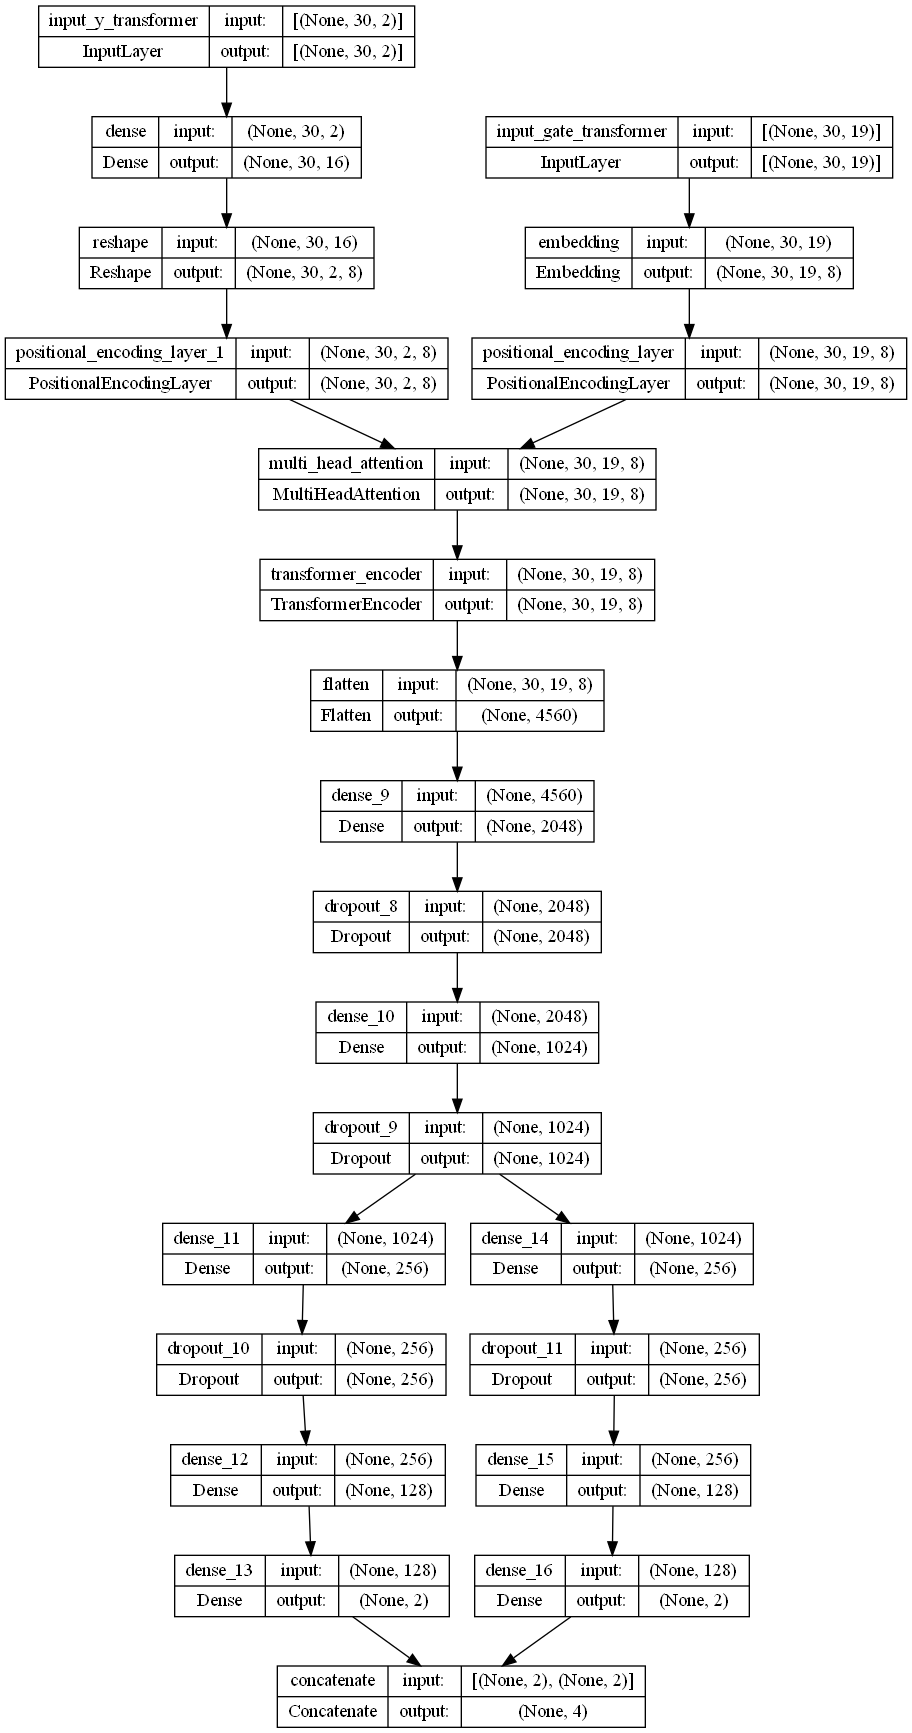

In [18]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [19]:
# def easy_PTM_depol_channel(depol_mat):
#   PTM_depol = (1-depol_mat)*np.eye(4)
#   PTM_depol[0,0] = 1
#   return PTM_depol

# def pauli_matrices():
#     """Return the Pauli matrices including identity."""
#     I = np.eye(2, dtype=complex)
#     X = np.array([[0, 1], [1, 0]], dtype=complex)
#     Y = np.array([[0, -1j], [1j, 0]], dtype=complex)
#     Z = np.array([[1, 0], [0, -1]], dtype=complex)
#     return [I, X, Y, Z]

# def compute_ideal_ptm(unitary):
#     """Compute the ideal PTM from a given unitary."""
#     paulis = pauli_matrices()
#     ptm_ideal = np.zeros((4, 4), dtype=complex)

#     for i in range(4):
#         for j in range(4):
#             ptm_ideal[i, j] = 0.5 * np.trace(np.dot(paulis[i], np.dot(unitary, np.dot(paulis[j], np.conjugate(unitary.T)))))
#     return ptm_ideal

# def general_custom_gate(theta, delta, depol_amt, gate):
#   # Parameters
#   # theta = np.pi / 2  # Example theta (45 degrees)
#   # delta = 0.1  # Over-rotational error in radians
#   # depolarizing_error = 0.01  # Depolarizing error rate

#   # Calculate PTM for ideal Rx(theta + delta) rotation including the over-rotational error
#   unitary_rx_adjusted = np.cos((theta + delta) / 2) * np.eye(2) - 1j * np.sin((theta + delta) / 2) * pauli_matrices()[gate]
#   ptm_adjusted_rx = compute_ideal_ptm(unitary_rx_adjusted)

#   # Calculate combined PTM with depolarizing error
#   ptm = np.dot(easy_PTM_depol_channel(depol_amt), ptm_adjusted_rx)

#   return ptm.real

# # print('ptm_adjusted_rx: \n', np.round(ptm_adjusted_rx,5))
# # print('final ptm: \n', np.round(ptm,5))


In [20]:
# Tensorflow does not support numpy array operations for backprop
# def easy_PTM_depol_channel(depol_mat):
#     PTM_depol = (1 - np.abs(depol_mat)) * np.eye(4)
#     # Create a new tensor with the modified value at index [0, 0]
#     PTM_depol = np.array(PTM_depol)
#     PTM_depol[0, 0] = 1
#     PTM_depol = tf.convert_to_tensor(PTM_depol, dtype=tf.complex64)
#     return PTM_depol

def easy_PTM_depol_channel(depol_mat):
    identity = tf.eye(4, dtype=tf.float32)
    PTM_depol = (1 - tf.math.abs(depol_mat)) * identity
    
    # Update the value at index [0,0] to 1
    # We use Tensorflow operations to ensure gradient computation
    PTM_depol = tf.tensor_scatter_nd_update(PTM_depol, [[0,0]], [1])
    PTM_depol = tf.cast(PTM_depol, dtype=tf.complex64)
    return PTM_depol



def pauli_matrices():
    """Return the Pauli matrices including identity."""
    I = tf.eye(2, dtype=tf.complex64)
    X = tf.constant([[0, 1], [1, 0]], dtype=tf.complex64)
    Y_imag = tf.constant([[0, -1], [1, 0]], dtype=tf.float32)
    Y_real = tf.constant([[0, 0], [0, 0]], dtype=tf.float32)
    Y = tf.complex(Y_real, Y_imag)
    # Y = tf.constant([[0, -1j], [1j, 0]], dtype=tf.complex64)
    Z = tf.constant([[1, 0], [0, -1]], dtype=tf.complex64)
    
    return [I, X, Y, Z]

def compute_ideal_ptm(unitary):
    """Compute the ideal PTM from a given unitary."""
    paulis = pauli_matrices()
    ptm_ideal = tf.zeros((4, 4), dtype=tf.complex64)

    for i in range(4):
        for j in range(4):
            term = tf.matmul(unitary, tf.matmul(paulis[j], tf.linalg.adjoint(unitary)))
            trace_value = 0.5 * tf.linalg.trace(tf.matmul(paulis[i], term))
            
            # Update ptm_ideal at position [i, j] with the calculated trace_value
            indices = tf.constant([[i, j]])
            ptm_ideal = tf.tensor_scatter_nd_add(ptm_ideal, indices, [trace_value])
            
    return ptm_ideal


def general_custom_gate(theta, delta, depol_amt, gate):
    # Compute real and imaginary parts as real numbers initially
    real_part = tf.cos((theta + delta) / 2)
    imag_part = tf.sin((theta + delta) / 2)
    
    # Cast them to complex numbers only when necessary
    unitary_rx_adjusted = tf.cast(real_part, dtype=tf.complex64) * tf.eye(2, dtype=tf.complex64) - 1j * tf.cast(imag_part, dtype=tf.complex64) * pauli_matrices()[gate]
    
    ptm_adjusted_rx = compute_ideal_ptm(unitary_rx_adjusted)
    ptm = tf.matmul(easy_PTM_depol_channel(depol_amt), ptm_adjusted_rx)
    
    return tf.math.real(ptm)


In [21]:
general_custom_gate(theta=math.pi/2, delta=0.1, depol_amt=0.01, gate=2)

<tf.Tensor: shape=(4, 4), dtype=float32, numpy=
array([[ 1.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        , -0.09883507,  0.        ,  0.9850541 ],
       [ 0.        ,  0.        ,  0.99      ,  0.        ],
       [ 0.        , -0.9850541 ,  0.        , -0.09883507]],
      dtype=float32)>

In [22]:
# # Custom X gate
# def custom_X(depol_amt, over_rotation):

#   # print(f'depol_amt: {self.depol_amt}, over_rotation: {self.over_rotation}')

#   theta = (math.pi/4 + over_rotation)/2
#   a = 1.0-depol_amt
#   b = a*2*tf.math.cos(theta)*tf.math.sin(theta)
#   c = a*(tf.math.sin(theta)**2 - tf.math.cos(theta)**2)

#   # print(f'a: {a}, b: {b}, c: {c}')

#   # ._ptr is a member of DenseOperator and is a numpy array that is
#   # the dense Pauli transfer matrix of this operator
#   # Technical note: use [:,:] instead of direct assignment so id of self._ptr doesn't change
#   custom_X_arr = tf.convert_to_tensor([[1,   0,   0,   0],
#                             [0,   a,   0,   0],
#                             [0,   0,   c,  -b],
#                             [0,   0,   b,   c]], dtype=tf.float32)

#   return custom_X_arr

def custom_X(depol_amt, over_rotation):
  # custom_X_arr = tf.convert_to_tensor(general_custom_gate, dtype=tf.float32)
  return general_custom_gate(theta=math.pi/2, delta=over_rotation, depol_amt=depol_amt, gate=1)

def custom_Y(depol_amt, over_rotation):
  # custom_Y_arr = tf.convert_to_tensor(general_custom_gate, dtype=tf.float32)
  return general_custom_gate(theta=math.pi/2, delta=over_rotation, depol_amt=depol_amt, gate=2)


def custom_gate_set(depol_amt_X, over_rotation_X, depol_amt_Y, over_rotation_Y):
  # Define gates in PTM form
  
  I = tf.constant([[1, 0, 0, 0],
                  [0, 1, 0, 0],
                  [0, 0, 1, 0],
                  [0, 0, 0, 1]], dtype=tf.float32)  #Gi

  # Normalized State corresponding to |0⟩ in Pauli basis
  # state_np = np.array([1/np.sqrt(2), 0, 0, 1/np.sqrt(2)], dtype=np.float32)

  X_theta = custom_X(depol_amt_X, over_rotation_X)
  Y_theta = custom_Y(depol_amt_Y, over_rotation_Y)
  
  

  return [X_theta, Y_theta, I]
  

  
# Define gate application function
def apply_gate(state, gate_set, label):
    
    # print(f"label: {label}")
  
    X_theta = gate_set[0]
    Y_theta = gate_set[1]
    I = gate_set[2]
    
    # print(f"X_theta: {X_theta}")
    # print(f"Y_theta: {Y_theta}")
    # print(f"I: {I}")
    
    if label == 1:
        return tf.linalg.matmul(X_theta, tf.reshape(state, [-1, 1]))
    elif label == 2:
        return tf.linalg.matmul(Y_theta, tf.reshape(state, [-1, 1]))
    elif label == 3:
        return tf.linalg.matmul(I, tf.reshape(state, [-1, 1]))
    else:
        return state  # If label is 0, don't apply any gate  

  
# # Define gate application function
# def apply_gate(state, depol_amt_X, over_rotation_X, depol_amt_Y, over_rotation_Y, label):
#     # Construct arrays using NumPy
#     # Define gates in PTM form
#     I = tf.constant([[1, 0, 0, 0],
#                     [0, 1, 0, 0],
#                     [0, 0, 1, 0],
#                     [0, 0, 0, 1]], dtype=tf.float32)  #Gi
    
#     # Normalized State corresponding to |0⟩ in Pauli basis
#     # state_np = np.array([1/np.sqrt(2), 0, 0, 1/np.sqrt(2)], dtype=np.float32)

#     X_theta = custom_X(depol_amt_X, over_rotation_X)
#     Y_theta = custom_Y(depol_amt_Y, over_rotation_Y)
    

#     # X_theta = tf.convert_to_tensor([[1, 0, 0, 0], [0, tf.math.cos(theta_value), 0, tf.math.sin(theta_value)],
#     #                        [0, 0, 1, 0], [0, -tf.math.sin(theta_value), 0, tf.math.cos(theta_value)]], dtype=tf.float32)  # Gx


#     # print('current label: ', label)

#     if label == 1:
#         return tf.linalg.matmul(X_theta, tf.reshape(state, [-1, 1]))
#     elif label == 2:
#         return tf.linalg.matmul(Y_theta, tf.reshape(state, [-1, 1]))
#     elif label == 3:
#         return tf.linalg.matmul(I, tf.reshape(state, [-1, 1]))
#     else:
#         return state  # If label is 0, don't apply any gate


# def apply_gate_sequence(single_gate_sequence):
#     # Initialize state in Pauli basis
#     state = tf.convert_to_tensor([1/np.sqrt(2), 0, 0, 1/np.sqrt(2)], dtype=tf.float32)

#   # Apply each gate in the sequence
#     # print('model(single_gate_sequence[tf.newaxis, :]) ->', model(single_gate_sequence[tf.newaxis, :]))
#     depol_amt, over_rotation = tf.squeeze(model(single_gate_sequence[tf.newaxis, :])) # Predict depolar_error, over_rotation for the current gate sequence
#     # print('theta_value: ', theta_value)
#     # depol_amt = tf.clip_by_value(tf.squeeze(depol_amt), 0, 0.1)
#     # over_rotation = tf.clip_by_value(tf.squeeze(over_rotation), 0, 0.1)
#     # print(f"depol_amt: {depol_amt}, over_rotation: {over_rotation}")
#     # print('squeezed theta_value: ', theta_value)
#     for i in range(tf.shape(single_gate_sequence)[0]):
#       if single_gate_sequence[i] == 0:
#         break
#       # print('tf.shape(single_gate_sequence): ', tf.shape(single_gate_sequence))
#       # print('tf.shape(single_gate_sequence[0]): ', tf.shape(single_gate_sequence)[0])
#       # print('single_gate_sequence[i]: ', single_gate_sequence[i])
#       state = apply_gate(state, depol_amt, over_rotation, single_gate_sequence[i])
#       # print('current state: ', state)

#     return state

# def apply_gate_sequence(single_gate_sequence, single_y_label, single_gate_matrix_sequence):
#     # Initialize state in Pauli basis
#     state = tf.constant([1/math.sqrt(2), 0, 0, 1/math.sqrt(2)], dtype=tf.float32)

#     # print("Shape of single_gate_sequence:", tf.shape(single_gate_sequence))
#     # print("Shape of single_y_label:", tf.shape(single_y_label))
#     # print("Shape of model input single_gate_sequence:", tf.shape(single_gate_sequence[tf.newaxis, :]))
#     # print("Shape of model input single_gate_sequence:", tf.shape(single_y_label[tf.newaxis, :]))


#     # Apply each gate in the sequence
#     depol_amt_X, over_rotation_X, depol_amt_Y, over_rotation_Y  = tf.squeeze(model([single_gate_matrix_sequence[tf.newaxis, :], single_y_label[tf.newaxis, :]])) # Predict depolar_error, over_rotation for the current gate sequence
#     reconstructed_gate_set = custom_gate_set(depol_amt_X, over_rotation_X, depol_amt_Y, over_rotation_Y)
#     for i in range(tf.shape(single_gate_sequence)[0]):
#         # print(f'single_gate_sequence{i}: {single_gate_sequence[i]}')
#         if single_gate_sequence[i] == 0:
#             break
#         state = apply_gate(state, reconstructed_gate_set, single_gate_sequence[i])

#     return state

def apply_gate_sequence(grouped_gate_sequence, grouped_y_label, grouped_gate_matrix_sequence, grouped_model_output):
    # Initialize a list to collect final states for each data point in the group
    grouped_final_states = []
    
#     print("Debug in apply_gate_sequence:")
#     print("Shape of grouped_gate_sequence:", tf.shape(grouped_gate_sequence))
    
#     print("Shape of grouped_gate_sequence:", tf.shape(grouped_gate_sequence))
    
    # Iterate through each data point within the group
    for i in range(tf.shape(grouped_gate_sequence)[0]):
        # print(f"current gate sequence number: {i}")
        single_gate_sequence = tf.gather(grouped_gate_sequence, i, axis=0)
        
        # Debug prints
        # print("Before tf.gather:")
        # print("Shape of grouped_gate_sequence:", tf.shape(grouped_gate_sequence))
        # print("After tf.gather:")
        # print("Shape of single_gate_sequence:", tf.shape(single_gate_sequence))
        
        single_y_label = tf.gather(grouped_y_label, i, axis=0)
        single_gate_matrix_sequence = tf.gather(grouped_gate_matrix_sequence, i, axis=0)
        
        # Initialize state in Pauli basis
        state = tf.constant([1/math.sqrt(2), 0, 0, 1/math.sqrt(2)], dtype=tf.float32)
        
        # Extract the model output corresponding to this data point
        depol_amt_X, depol_amt_Y, over_rotation_X, over_rotation_Y = grouped_model_output
        
        # Single depolarizaing error prediction
#         depol_amt_XY, over_rotation_X, over_rotation_Y = grouped_model_output
  
#         depol_amt_X = depol_amt_XY
#         depol_amt_Y = depol_amt_XY
        
        # Debugging purpose, depolarizing noise are fixed to grounth truth values to test the predictability of ONLY over_rotations
        # depol_amt_X = 0.01
        # depol_amt_Y = 0.01
        
        # Debugging purpose, over_rotations are fixed to grounth truth values to test the predictability of ONLY depolarizing noise
        # over_rotation_X = 0.1
        # over_rotation_Y = 0.15
        
        
        # print(f'depol_amt_X: {depol_amt_X}, over_rotation_X: {over_rotation_X}, depol_amt_Y: {depol_amt_Y}, over_rotation_Y: {over_rotation_Y}')

        
        # Reconstruct the gate set using the predicted depolarization and over-rotation
        reconstructed_gate_set = custom_gate_set(depol_amt_X, over_rotation_X, depol_amt_Y, over_rotation_Y)
        
        

        # Apply each gate in the sequence
        debug_label_arr = []
        for j in range(tf.shape(single_gate_sequence)[0]):
            debug_label_arr.append(single_gate_sequence[j])
            if single_gate_sequence[j] == 0:
                # print(f"current gate sequence: {debug_label_arr}")
                # print(f"length of current gate sequence: {len(debug_label_arr)}")
                break
            state = apply_gate(state, reconstructed_gate_set, single_gate_sequence[j])

        # Append the final state for this data point to the list of final states
        grouped_final_states.append(state)
        # print(f"Shape of current final state: {tf.shape(state)}")

    # Convert the list of final states into a tensor
    grouped_final_states = tf.stack(grouped_final_states)
    # print(f"Shape of current grouped final state: {tf.shape(grouped_final_states)}")
    
    return grouped_final_states



# def compute_probabilities(ptm_vector):
#     # PTM representations for |0> and |1> states
#     ptm_0 = tf.constant([1, 0, 0, 1], dtype=tf.float32)
#     ptm_1 = tf.constant([1, 0, 0, -1], dtype=tf.float32)
#     # ptm_0 = tf.convert_to_tensor([1, 0, 0, 1], dtype=tf.float32)
#     # ptm_1 = tf.convert_to_tensor([1, 0, 0, -1], dtype=tf.float32)

#     # Normalize the vectors
#     ptm_vector = tf.squeeze(tf.linalg.l2_normalize(ptm_vector))
#     ptm_0 = tf.linalg.l2_normalize(ptm_0)
#     ptm_1 = tf.linalg.l2_normalize(ptm_1)

#     # Compute dot products
#     prob_0 = tf.tensordot(ptm_vector, ptm_0, axes=1)
#     prob_1 = tf.tensordot(ptm_vector, ptm_1, axes=1)

#     return tf.stack([prob_0, prob_1])

def compute_probabilities(grouped_ptm_vector):
    # print("Debug in compute_probabilities:")
    
    # Remove singleton dimensions if any (like the last '1' in [10, 4, 1])
    grouped_ptm_vector = tf.squeeze(grouped_ptm_vector, axis=-1)
    
    # print(f"Shape of grouped_ptm_vector: {tf.shape(grouped_ptm_vector)}")
    
    # PTM representations for |0> and |1> states
    # ptm_0 = tf.constant([[1, 0, 0, 1]], dtype=tf.float32)
    # ptm_1 = tf.constant([[1, 0, 0, -1]], dtype=tf.float32)
    
    ptm_0 = tf.constant([1/math.sqrt(2), 0, 0, 1/math.sqrt(2)], dtype=tf.float32)
    ptm_1 = tf.constant([1/math.sqrt(2), 0, 0, -1/math.sqrt(2)], dtype=tf.float32)
    
    
    # print(f"Shape of ptm_0: {tf.shape(ptm_0)}")
    # print(f"Shape of ptm_1: {tf.shape(ptm_1)}")

    # Normalize the vectors
    # grouped_ptm_vector = tf.linalg.l2_normalize(grouped_ptm_vector, axis=-1)
    # ptm_0 = tf.linalg.l2_normalize(ptm_0)
    # ptm_1 = tf.linalg.l2_normalize(ptm_1)
    
    
    # print(f"Shape of normalized grouped_ptm_vector: {tf.shape(grouped_ptm_vector)}")
    # print(f"Shape of normalized ptm_0: {tf.shape(ptm_0)}")
    # print(f"Shape of normalized ptm_1: {tf.shape(ptm_1)}")

    # Compute dot products in a batched manner using broadcasting
    prob_0 = tf.reduce_sum(grouped_ptm_vector * ptm_0, axis=-1)
    prob_1 = tf.reduce_sum(grouped_ptm_vector * ptm_1, axis=-1)

    # # Perform batch dot product
    # prob_0 = tf.tensordot(grouped_ptm_vector, ptm_0, axes=[[-1], [-1]])
    # prob_1 = tf.tensordot(grouped_ptm_vector, ptm_1, axes=[[-1], [-1]])

    
    # print(f"Shape of prob_0: {tf.shape(prob_0)}")
    # print(f"Shape of prob_1: {tf.shape(prob_1)}")
    
    final_probabilities = tf.stack([prob_0, prob_1], axis=-1)
    # print(f"Shape of final_probabilities: {tf.shape(final_probabilities)}")
    
    return final_probabilities



# Define loss function
loss_fn = MeanSquaredError()
  

# def train_step(X, y, X_ms):
#     with tf.GradientTape() as tape:
#         # Predict depolarization and over-rotation for the current gate sequence
#         grouped_model_output = model([X_ms[0], X[1]])

#         # Process the entire group at once
#         print("The following are the prints from train_step")
#         print("Shape of grouped_gate_sequence: ", tf.shape(X[0]))
#         print("Shape of grouped_y_label: ", tf.shape(X[1]))
#         print("Shape of grouped_gate_matrix_sequence: ", tf.shape(X_ms[0]))
#         print("Shape of grouped_model_output: ", tf.shape(grouped_model_output))     
#         batched_final_states = apply_gate_sequence(X[0], X[1], X_ms[0], grouped_model_output)
#         batched_probabilities = compute_probabilities(batched_final_states)
        
#         loss = loss_fn(y, batched_probabilities)

#     grads = tape.gradient(loss, model.trainable_weights)
#     optimizer.apply_gradients(zip(grads, model.trainable_weights))
#     return loss
  



# def validate_step(X, y, X_ms, print_results = False):
#     batched_final_states = []
#     batched_probabilities = []
#     batched_values = []
#     batched_sum_depol_amt_X = 0
#     batched_sum_over_rotation_X = 0
#     batched_sum_depol_amt_Y = 0
#     batched_sum_over_rotation_Y = 0

#     for i in range(tf.shape(X[0])[0]):
#         single_sequence = tf.gather(X[0], i, axis=0)
#         single_mat_sequence = tf.gather(X_ms[0], i, axis=0)
#         single_y_label = tf.gather(X[1], i, axis=0)
#         final_state = apply_gate_sequence(single_sequence, single_y_label, single_mat_sequence)
#         # print(f'final_state_validating: {final_state}')
#         probabilities = compute_probabilities(final_state)
#         batched_final_states.append(final_state)
#         batched_probabilities.append(probabilities)
#         if print_results == True:
#             depol_amt_X, over_rotation_X, depol_amt_Y, over_rotation_Y = tf.squeeze(model([single_mat_sequence[tf.newaxis, :], single_y_label[tf.newaxis, :]])) # Predict depolar_error, over_rotation for the current gate sequence
#             batched_values.append(tf.stack([depol_amt_X, over_rotation_X, depol_amt_Y, over_rotation_Y]))
#             batched_sum_depol_amt_X += depol_amt_X
#             batched_sum_over_rotation_X += over_rotation_X
#             batched_sum_depol_amt_Y += depol_amt_Y
#             batched_sum_over_rotation_Y += over_rotation_Y

#     batched_final_states = tf.stack(batched_final_states)
#     batched_probabilities = tf.stack(batched_probabilities)
#     loss = loss_fn(y, batched_probabilities)
#     if print_results == True:
#         print('\nbatched_values: ', batched_values)
#         print('\nlen of batched_values: ', len(batched_values))
#         print('\nbatched_mean_depol_amt_X: ', batched_sum_depol_amt_X/len(batched_values))
#         print('\nbatched_over_rotation_X: ', batched_sum_over_rotation_X/len(batched_values))
#         print('\nbatched_mean_depol_amt_Y: ', batched_sum_depol_amt_Y/len(batched_values))
#         print('\nbatched_over_rotation_Y: ', batched_sum_over_rotation_Y/len(batched_values))
#     return loss

# def validate_step(X, y, X_ms, print_results=False):
#     # Predict depolarization and over-rotation for the current gate sequence
#     grouped_model_output = model([X_ms[0], X[1]])

#     # Process the entire group at once
#     batched_final_states = apply_gate_sequence(X[0], X[1], X_ms[0], grouped_model_output)
#     batched_probabilities = compute_probabilities(batched_final_states)
    
#     loss = loss_fn(y, batched_probabilities)

#     if print_results:
#         num_values = tf.shape(grouped_model_output)[0]
#         depol_amt_X, over_rotation_X, depol_amt_Y, over_rotation_Y = tf.split(grouped_model_output, 4, axis=1)
#         print('\nBatched Mean Depolarization Amount X:', tf.reduce_mean(depol_amt_X))
#         print('\nBatched Over Rotation X:', tf.reduce_mean(over_rotation_X))
#         print('\nBatched Mean Depolarization Amount Y:', tf.reduce_mean(depol_amt_Y))
#         print('\nBatched Over Rotation Y:', tf.reduce_mean(over_rotation_Y))

#     return loss


def train_step(X, y, X_ms):
    train_losses = []  # Initialize a list to collect the losses for each group in the mini-batch
    
    with tf.GradientTape() as tape:
        # Compute model output for the entire mini-batch here
        full_batch_model_output = model([X_ms[0], X[1]])
        # print("Shape of full_batch_model_output: ", tf.shape(full_batch_model_output))  # Debugging line
        
        # Loop over each group in the mini-batch
        for i in range(tf.shape(X[0])[0]):
            single_group_gate_sequence = tf.gather(X[0], i, axis=0)
            single_group_y_label = tf.gather(X[1], i, axis=0)
            single_group_gate_matrix_sequence = tf.gather(X_ms[0], i, axis=0)

            # Gather the model's output for the i-th group from the full batch output
            single_group_model_output = tf.gather(full_batch_model_output, i, axis=0)
            # print("Shape of single_group_model_output:", tf.shape(single_group_model_output))  # Debugging line

            # Process a single group
            final_states = apply_gate_sequence(single_group_gate_sequence, single_group_y_label, single_group_gate_matrix_sequence, single_group_model_output)
            # print("Shape of final_states:", tf.shape(final_states))  # Debugging line
            probabilities = compute_probabilities(final_states)
            # if i == 0:
            #     print(f"debugging computed probabilities: \n {probabilities}")
            
            # print("Shape of probabilities:", tf.shape(probabilities))  # Debugging line
            
            # Calculate loss for this group
            # print("tf.gather(y, i, axis=0):", tf.gather(y, i, axis=0))  # Debugging line
            loss = loss_fn(tf.gather(y, i, axis=0), probabilities)
            train_losses.append(loss)
            
        # Average the losses across the mini-batch
        average_loss = tf.reduce_mean(train_losses)
        # print("average_loss: ", average_loss)

    # Compute the gradients for the entire mini-batch and update model parameters
    grads = tape.gradient(average_loss, model.trainable_weights)
    
    # Debugging lines to print out gradients
    # for i, (grad, var) in enumerate(zip(grads, model.trainable_weights)):
    #     if grad is not None:
    #         print(f"Gradient for {var.name}, Max: {tf.math.reduce_max(grad)}, Min: {tf.math.reduce_min(grad)}")
    #     else:
    #         print(f"Gradient for {var.name} is None")
    
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    
    return average_loss, tf.squeeze(full_batch_model_output)


def validate_step(X, y, X_ms, print_results=False):
    val_losses = []  # Initialize a list to collect the losses for each group in the mini-batch
    
    # Initialize a list for printing and evaluating results
    batched_values = []
    batched_sum_depol_amt_X = 0
    batched_sum_over_rotation_X = 0
    batched_sum_depol_amt_Y = 0
    batched_sum_over_rotation_Y = 0

    # Compute model output for the entire mini-batch here
    full_batch_model_output = model([X_ms[0], X[1]])

    # Loop over each group in the mini-batch
    for i in range(tf.shape(X[0])[0]):
        single_group_gate_sequence = tf.gather(X[0], i, axis=0)
        single_group_y_label = tf.gather(X[1], i, axis=0)
        single_group_gate_matrix_sequence = tf.gather(X_ms[0], i, axis=0)

        # Gather the model's output for the i-th group from the full batch output
        single_group_model_output = tf.gather(full_batch_model_output, i, axis=0)

        # Process a single group
        final_states = apply_gate_sequence(single_group_gate_sequence, single_group_y_label, single_group_gate_matrix_sequence, single_group_model_output)
        probabilities = compute_probabilities(final_states)
        
        if print_results == True:
            # depol_amt_X, over_rotation_X, depol_amt_Y, over_rotation_Y = single_group_model_output
            depol_amt_X, depol_amt_Y, over_rotation_X, over_rotation_Y = single_group_model_output
            batched_values.append(tf.stack([depol_amt_X, over_rotation_X, depol_amt_Y, over_rotation_Y]))
            batched_sum_depol_amt_X += depol_amt_X
            batched_sum_over_rotation_X += over_rotation_X
            batched_sum_depol_amt_Y += depol_amt_Y
            batched_sum_over_rotation_Y += over_rotation_Y
        

        # Calculate loss for this group
        loss = loss_fn(tf.gather(y, i, axis=0), probabilities)
        val_losses.append(loss)

    # Average the losses across the mini-batch
    average_loss = tf.reduce_mean(val_losses)
    
    if print_results == True:
        print('\nbatched_values: ', batched_values)
        print('\nlen of batched_values: ', len(batched_values))
        print('\nbatched_mean_depol_amt_X: ', batched_sum_depol_amt_X/len(batched_values))
        print('\nbatched_over_rotation_X: ', batched_sum_over_rotation_X/len(batched_values))
        print('\nbatched_mean_depol_amt_Y: ', batched_sum_depol_amt_Y/len(batched_values))
        print('\nbatched_over_rotation_Y: ', batched_sum_over_rotation_Y/len(batched_values))
    
    
    return average_loss



In [23]:
# Directory to save the model and weights
model_save_dir = "saved_models"
if not os.path.exists(model_save_dir):
    os.makedirs(model_save_dir)

In [24]:
# for i in range (0,2):
#   print(tf.shape(tf.gather(X_train[0][0], i, axis=0)))
#   print(tf.gather(X_train[0][0], i, axis=0))

In [25]:
len(X_train[0])

382

In [26]:
len(X_train[0][0])

19

In [27]:
len(X_train_0)

382

In [28]:
debug_X, debug_y = prepare_data(df_sorted.iloc[:339]) # DO NOT USE panda iloc method!!!

In [29]:
len(debug_X)

339

In [30]:
new_debug_X = X_train_0
new_debug_y = y_train

In [31]:
len(new_debug_X[:339])

339

In [32]:
# np.linalg.norm(new_debug_X-new_debug_X[:339])

In [33]:
tf.get_logger().setLevel('ERROR')

In [34]:
# # Reshape function
# def reshape_for_grouping(data, group_size):
#     n_samples = data.shape[0]
#     n_batches = n_samples // group_size
#     remainder = n_samples % group_size
#     if remainder:
#         padding_shape = [group_size - remainder] + list(data.shape[1:])
#         padding = np.zeros(padding_shape)
#         data = np.concatenate([data, padding], axis=0)
#     return data.reshape(-1, group_size, *data.shape[1:])


def reshape_for_grouping(data, group_size):
    """
    Reshape the data for grouping with repeating the last indices in case of remainder.
    
    Parameters:
        data (numpy.ndarray): The data to be reshaped.
        group_size (int): The desired group size.
        
    Returns:
        numpy.ndarray: The reshaped data.
    """
    n_samples = data.shape[0]
    n_batches = n_samples // group_size
    remainder = n_samples % group_size
    
    # If the remainder exists, pad the data by repeating the last indices
    if remainder:
        padding_count = group_size - remainder
        padding_indices = [-i % n_samples - 1 for i in range(padding_count)]
        padding = data[padding_indices]
        data = np.concatenate([data, padding], axis=0)
        
    return data.reshape(-1, group_size, *data.shape[1:])

# group_size = 30  # Set this to your desired group size

X_train_0_grouped = reshape_for_grouping(X_train_0, group_size)
y_train_grouped = reshape_for_grouping(y_train, group_size)
X_train_grouped = [reshape_for_grouping(X, group_size) for X in X_train]

# X_test_0_grouped = reshape_for_grouping(X_test_0, group_size)
# y_test_grouped = reshape_for_grouping(y_test, group_size)
# X_test_grouped = [reshape_for_grouping(X, group_size) for X in X_test]

In [35]:
# Test the function again with test data of size 3
test_data_small = np.array([[1, 2], [3, 4], [5, 6], [7, 8], [9, 10], [10, 11]])
reshaped_test_data_small = reshape_for_grouping(test_data_small, group_size)
reshaped_test_data_small

array([[[ 1,  2],
        [ 3,  4],
        [ 5,  6],
        [ 7,  8],
        [ 9, 10],
        [10, 11],
        [10, 11],
        [ 9, 10],
        [ 7,  8],
        [ 5,  6],
        [ 3,  4],
        [ 1,  2],
        [10, 11],
        [ 9, 10],
        [ 7,  8],
        [ 5,  6],
        [ 3,  4],
        [ 1,  2],
        [10, 11],
        [ 9, 10],
        [ 7,  8],
        [ 5,  6],
        [ 3,  4],
        [ 1,  2],
        [10, 11],
        [ 9, 10],
        [ 7,  8],
        [ 5,  6],
        [ 3,  4],
        [ 1,  2]]])

In [36]:
# Training loop
EPOCHS = 100
num_parts = 4
part_size = len(X_train_0_grouped) // num_parts
print(f"Length of X_train_0_grouped: {len(X_train_0_grouped)}")
print(f"part size: {part_size}")

# Lists to store the mean train and validation losses for each epoch
all_train_losses = []
all_train_predicted_values = []
# all_train_unified_depolar = []
all_train_X_depolar = []
all_train_Y_depolar = []
all_train_predicted_X_overrotation = []
all_train_predicted_Y_overrotation = []
# all_val_losses = []

# List to store learning rates
learning_rates = []

total_epochs_elapsed = 0  # Counter for the total number of epochs elapsed

end_idx = 0  # Initialize end_idx to zero


for part in range(num_parts):
    # Determine the dataset subset for the current part
    start_idx = part * part_size
    end_idx = (part + 1) * part_size  # Exclusive
    
    print(f"start_idx: {start_idx}")
    print(f"end_idx: {end_idx}")
    
    # end_idx += part_size  # Increment the end_idx by part_size

    X_subset = X_train_0_grouped[start_idx:end_idx]
    print(f"Shape of X_subset: {X_subset.shape}")

    y_subset = y_train_grouped[start_idx:end_idx]
    print(f"Shape of y_subset: {y_subset.shape}")

    X_subset_ms = [X_train_grouped[0][start_idx:end_idx], X_train_grouped[1][start_idx:end_idx]]

    for epoch in range(EPOCHS):
        train_losses_per_epoch = []
        predicted_values_per_epoch = np.zeros(4) # Initialize zeros array, number of zeros corresponds to model output dimension 
        predicted_values_counter_per_epoch = 0 
        # val_losses_per_epoch = []

        for i in range(len(X_subset)):
            X_batch = [X_subset[i:i + 1], y_subset[i:i + 1]]
            X_batch_ms = [X_subset_ms[0][i:i + 1], X_subset_ms[1][i:i + 1]]
            y_batch = y_subset[i:i + 1]

            # train_loss, train_predicted_values = train_step(X_batch, y_batch, X_batch_ms)
            train_loss, train_predicted_values = train_step(X_batch, y_batch, X_batch)
            
            
            # val_loss = validate_step([X_test_0_grouped, y_test_grouped], y_test_grouped, [X_test_grouped[0], X_test_grouped[1]])
            train_losses_per_epoch.append(train_loss)
            # print(f"current_predicted_values: {train_predicted_values}")
            predicted_values_per_epoch = predicted_values_per_epoch + np.array(train_predicted_values)
            predicted_values_counter_per_epoch += 1
            # print(f"predicted_values_per_epoch: {predicted_values_per_epoch}")
            
                
            # val_losses_per_epoch.append(val_loss)

        mean_train_loss = np.mean(train_losses_per_epoch)
        mean_predicted_values = predicted_values_per_epoch/predicted_values_counter_per_epoch
        # print(f"predicted_values_counter_per_epoch: {predicted_values_counter_per_epoch}")
        # print(f"mean_predicted_values: {mean_predicted_values}")
        # mean_val_loss = np.mean(val_losses_per_epoch)

        # Store the mean losses for this epoch
        all_train_losses.append(mean_train_loss)
        all_train_predicted_values.append(mean_predicted_values)
        
        all_train_X_depolar.append(mean_predicted_values[0])
        all_train_Y_depolar.append(mean_predicted_values[1])
        all_train_predicted_X_overrotation.append(mean_predicted_values[2])
        all_train_predicted_Y_overrotation.append(mean_predicted_values[3])
            
        
        # all_val_losses.append(mean_val_loss)

        # Record the learning rate at this epoch
        current_step = model.optimizer.iterations
        current_lr = lr_schedule(current_step).numpy()
        learning_rates.append(current_lr)

        total_epochs_elapsed += 1
        # print(f"Part: {part+1}/{num_parts}, Epoch: {epoch+1}/{EPOCHS}, Total Epochs: {total_epochs_elapsed}, Train Loss: {mean_train_loss}, Validation Loss: {mean_val_loss}, Learning Rate: {current_lr}")
        print(f"Part: {part+1}/{num_parts}, Epoch: {epoch+1}/{EPOCHS}, Total Epochs: {total_epochs_elapsed}, Train Loss: {mean_train_loss}, Learning Rate: {current_lr}")
        if (total_epochs_elapsed % 10 == 0) or (total_epochs_elapsed == 1) or (epoch+1 == EPOCHS):
            model_path = os.path.join(model_save_dir, f"model_epoch_{total_epochs_elapsed}")
            weights_path = os.path.join(model_save_dir, f"weights_epoch_{total_epochs_elapsed}")
            # tf.debugging.disable_traceback_filtering()
            # model.save(model_path)
            if (total_epochs_elapsed % 100 == 0) or (epoch+1 == EPOCHS):
                model.save(f"{model_path}.keras", save_format='keras')
            # model.save_weights(weights_path)
                print(f"Model and weights saved at epoch {total_epochs_elapsed}")          

            loss_lr_df = pd.DataFrame({
                'Epoch': list(range(1, len(all_train_losses) + 1)),
                'Training_Loss': all_train_losses,
                'Learning_Rate': learning_rates # Include learning rates
            })
            
            predicted_values_df = pd.DataFrame({
                'Epoch': list(range(1, len(all_train_predicted_values) + 1)),
                'Predicted_Values': all_train_predicted_values,
                'X_Depolarizing_Error': all_train_X_depolar,
                'Y_Depolarizing_Error': all_train_Y_depolar,
                'X_Over_Rotation_Error': all_train_predicted_X_overrotation,
                'Y_Over_Rotation_Error':all_train_predicted_Y_overrotation
            })
            
            # Save the DataFrame to a CSV file
            loss_lr_df.to_csv(f'losses_and_lr_epoch_{total_epochs_elapsed}.csv', index=False)
            predicted_values_df.to_csv(f'predicted_values_epoch_{total_epochs_elapsed}.csv', index=False)

            print(f"Losses and learning rates saved at epoch {total_epochs_elapsed}")
            

        if (part+1) != num_parts:
            if mean_train_loss <= 2.5e-5:
                print(f"mean_train_loss: {mean_train_loss} <= 2.5e-5, skip to next stage.")
                break
                
        
    


Length of X_train_0_grouped: 13
part size: 3
start_idx: 0
end_idx: 3
Shape of X_subset: (3, 30, 19)
Shape of y_subset: (3, 30, 2)
Part: 1/4, Epoch: 1/100, Total Epochs: 1, Train Loss: 0.06658151745796204, Learning Rate: 9.999999974752427e-07
Losses and learning rates saved at epoch 1
Part: 1/4, Epoch: 2/100, Total Epochs: 2, Train Loss: 0.06374183297157288, Learning Rate: 9.999999974752427e-07
Part: 1/4, Epoch: 3/100, Total Epochs: 3, Train Loss: 0.05866602063179016, Learning Rate: 9.999999974752427e-07
Part: 1/4, Epoch: 4/100, Total Epochs: 4, Train Loss: 0.049609001725912094, Learning Rate: 9.999999974752427e-07
Part: 1/4, Epoch: 5/100, Total Epochs: 5, Train Loss: 0.03514695167541504, Learning Rate: 9.999999974752427e-07
Part: 1/4, Epoch: 6/100, Total Epochs: 6, Train Loss: 0.018477842211723328, Learning Rate: 9.999999974752427e-07
Part: 1/4, Epoch: 7/100, Total Epochs: 7, Train Loss: 0.014940631575882435, Learning Rate: 9.999999974752427e-07
Part: 1/4, Epoch: 8/100, Total Epochs: 8

In [ ]:
# Save the entire model as a `.keras` zip archive.
model.save('my_model.keras')

In [ ]:
test_saved_model = tf.keras.models.load_model('my_model.keras')

In [ ]:
saved_model = tf.keras.models.load_model(r"C:\Users\ALAN\Documents\ML4GST\saved_models\model_epoch_600.keras")

In [ ]:
random_data_x = np.random.rand(1,20,4,4)
random_data_y = np.random.rand(1,2)

In [ ]:
model([random_data_x, random_data_y])

In [ ]:
saved_model([random_data_x, random_data_y])

In [ ]:
saved_model.optimizer.iterations

In [ ]:
# Create a new Adam optimizer with the desired learning rate
new_learning_rate = 1e-6
new_optimizer = tf.keras.optimizers.Adam(learning_rate=new_learning_rate)

# Compile the model with the new optimizer
saved_model.compile(optimizer=new_optimizer, loss='mean_squared_error')


In [ ]:
saved_model.optimizer.learning_rate.numpy()

In [ ]:
# Plotting training and validation losses
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(all_train_losses, label='Training Loss')
# plt.plot(all_val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Losses')
plt.show()

In [ ]:
plt.plot(learning_rates)
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Custom Learning Rate Schedule')
plt.show()

In [ ]:
# # Convert the recorded losses into a DataFrame
# loss_df = pd.DataFrame({
#     'Epoch': list(range(1, len(all_train_losses) + 1)),
#     'Training_Loss': all_train_losses,
#     'Validation_Loss': all_val_losses
# })

# # Save the DataFrame to a CSV file
# loss_df.to_csv('losses.csv', index=False)


In [ ]:
# Function to sample part of the training data and evaluate model's performance
def sample_and_evaluate(num_samples=13):
    indices = np.random.choice(len(X_train_grouped[0]), size=num_samples, replace=False)
    # indices = [i for i in range(5)]
    sampled_X = [tf.cast(X_train_0_grouped[indices], dtype=tf.float32), tf.cast(y_train_grouped[indices], dtype=tf.float32)]
    sampled_y = tf.cast(y_train_grouped[indices], dtype=tf.float32)
    sampled_X_ms = [tf.cast(X_train_grouped[0][indices], dtype=tf.float32), tf.cast(X_train_grouped[1][indices], dtype=tf.float32)]
    loss = validate_step(sampled_X, sampled_y, sampled_X_ms, print_results = True)
    print(f"Loss on sampled data: {loss.numpy()}")
    return loss.numpy()

In [ ]:
# X_train[0][0]

In [ ]:
sample_and_evaluate()

In [ ]:
# Function to sample part of the training data and evaluate model's performance
def sample_and_evaluate_single(num_samples=13):
    # indices = np.random.choice(len(X_train_grouped[0]), size=num_samples, replace=False)
    indices = [28]
    sampled_X = [tf.cast(X_train_0_grouped[indices], dtype=tf.float32), tf.cast(y_train_grouped[indices], dtype=tf.float32)]
    sampled_y = tf.cast(y_train_grouped[indices], dtype=tf.float32)
    sampled_X_ms = [tf.cast(X_train_grouped[0][indices], dtype=tf.float32), tf.cast(X_train_grouped[1][indices], dtype=tf.float32)]
    loss = validate_step(sampled_X, sampled_y, sampled_X_ms, print_results = True)
    print(f"Loss on sampled data: {loss.numpy()}")
    return loss.numpy()

In [ ]:
sample_and_evaluate_single()

In [ ]:
def apply_gate_sequence_ground_truth(single_gate_sequence, single_y_label, single_gate_matrix_sequence, ground_truth_params):
    # Initialize state in Pauli basis
    state = tf.constant([1/math.sqrt(2), 0, 0, 1/math.sqrt(2)], dtype=tf.float32)

    # print("Shape of single_gate_sequence:", tf.shape(single_gate_sequence))
    # print("Shape of single_y_label:", tf.shape(single_y_label))
    # print("Shape of model input single_gate_sequence:", tf.shape(single_gate_sequence[tf.newaxis, :]))
    # print("Shape of model input single_gate_sequence:", tf.shape(single_y_label[tf.newaxis, :]))


    # Apply each gate in the sequence
    depol_amt_X, depol_amt_Y, over_rotation_X, over_rotation_Y  = ground_truth_params
    reconstructed_gate_set = custom_gate_set(depol_amt_X, over_rotation_X, depol_amt_Y, over_rotation_Y)
    for i in range(tf.shape(single_gate_sequence)[0]):
        # print(f'single_gate_sequence{i}: {single_gate_sequence[i]}')
        if single_gate_sequence[i] == 0:
            break
        state = apply_gate(state, reconstructed_gate_set, single_gate_sequence[i])

    return state

In [ ]:
def validate_step_ground_truth(X, y, X_ms, ground_truth_params, print_results = False):
    val_losses = []  # Initialize a list to collect the losses for each group in the mini-batch
    
    # Initialize a list for printing and evaluating results
    batched_values = []
    batched_sum_depol_amt_X = 0
    batched_sum_over_rotation_X = 0
    batched_sum_depol_amt_Y = 0
    batched_sum_over_rotation_Y = 0

    # # Compute model output for the entire mini-batch here
    # full_batch_model_output = model([X_ms[0], X[1]])

    # Loop over each group in the mini-batch
    for i in range(tf.shape(X[0])[0]):
        single_group_gate_sequence = tf.gather(X[0], i, axis=0)
        single_group_y_label = tf.gather(X[1], i, axis=0)
        single_group_gate_matrix_sequence = tf.gather(X_ms[0], i, axis=0)

        # Gather the model's output for the i-th group from the full batch output
        # single_group_model_output = tf.gather(full_batch_model_output, i, axis=0)
        single_group_model_output = ground_truth_params

        # Process a single group
        final_states = apply_gate_sequence(single_group_gate_sequence, single_group_y_label, single_group_gate_matrix_sequence, ground_truth_params)
        probabilities = compute_probabilities(final_states)
        
        if print_results == True:
            depol_amt_X, depol_amt_Y, over_rotation_X, over_rotation_Y = ground_truth_params
            batched_values.append(tf.stack([depol_amt_X, over_rotation_X, depol_amt_Y, over_rotation_Y]))
            batched_sum_depol_amt_X += depol_amt_X
            batched_sum_over_rotation_X += over_rotation_X
            batched_sum_depol_amt_Y += depol_amt_Y
            batched_sum_over_rotation_Y += over_rotation_Y
        
        
        print(f"Ground truth probabilities: {tf.gather(y, i, axis=0)}")
        print(f"Computed probabilities: {probabilities}")
        # Calculate loss for this group
        loss = loss_fn(tf.gather(y, i, axis=0), probabilities)
        val_losses.append(loss)

    # Average the losses across the mini-batch
    average_loss = tf.reduce_mean(val_losses)
    
    if print_results == True:
        print('\nbatched_values: ', batched_values)
        print('\nlen of batched_values: ', len(batched_values))
        print('\nbatched_mean_depol_amt_X: ', batched_sum_depol_amt_X/len(batched_values))
        print('\nbatched_over_rotation_X: ', batched_sum_over_rotation_X/len(batched_values))
        print('\nbatched_mean_depol_amt_Y: ', batched_sum_depol_amt_Y/len(batched_values))
        print('\nbatched_over_rotation_Y: ', batched_sum_over_rotation_Y/len(batched_values))
    
    
    return average_loss

In [ ]:
# Function to sample part of the training data and evaluate model's performance
def sample_and_evaluate_ground_truth(ground_truth_params, num_samples=10):
    # indices = np.random.choice(len(X_train_grouped[0]), size=num_samples, replace=False)
    indices = [i for i in range(0,17)]
    print(f"indices: {indices}")
    sampled_X = [tf.cast(X_train_0_grouped[indices], dtype=tf.float32), tf.cast(y_train_grouped[indices], dtype=tf.float32)]
    sampled_y = tf.cast(y_train_grouped[indices], dtype=tf.float32)
    print(f"sampled_y: {sampled_y}")
    sampled_X_ms = [tf.cast(X_train_grouped[0][indices], dtype=tf.float32), tf.cast(X_train_grouped[1][indices], dtype=tf.float32)]
    loss = validate_step_ground_truth(sampled_X, sampled_y, sampled_X_ms, ground_truth_list, print_results = True)
    print(f"Loss on sampled data: {loss.numpy()}")
    return loss.numpy()

In [ ]:
ground_truth_list = [0.01, 0.01, 0.1, 0.15]

In [ ]:
sample_and_evaluate_ground_truth(ground_truth_list)

In [ ]:
custom_gate_set(0.01, 0.1, 0.01, 0.15)[0]

In [ ]:
custom_gate_set(0.0, 0.0, 0.0, 0.0)[0]

In [ ]:
debug_X_pi_gate = tf.linalg.matmul(custom_gate_set(0.0, 0.0, 0.0, 0.0)[0], custom_gate_set(0.0, 0.0, 0.0, 0.0)[0])

In [ ]:
debug_X_pi_gate

In [ ]:
debug_X_2pi_gate = tf.linalg.matmul(debug_X_pi_gate, debug_X_pi_gate)

In [ ]:
debug_X_2pi_gate

In [ ]:
np.linalg.norm(debug_X_2pi_gate - np.eye(4))

In [ ]:
debug_init_state_0 = tf.constant([1/math.sqrt(2), 0, 0, 1/math.sqrt(2)], dtype=tf.float32)

In [ ]:
debug_init_state_1 = tf.constant([1/math.sqrt(2), 0, 0, -1/math.sqrt(2)], dtype=tf.float32)

In [ ]:
debug_final_state = tf.linalg.matmul(custom_gate_set(0.01, 0.1, 0.01, 0.15)[0], tf.reshape(debug_init_state_0, [-1,1]))

In [ ]:
debug_final_state

In [ ]:
compute_probabilities(debug_final_state)

In [ ]:
debug_final_state_2 = tf.linalg.matmul(custom_gate_set(0.0, 0.0, 0.0, 0.0)[0], tf.reshape(debug_final_state, [-1,1]))

In [ ]:
compute_probabilities(debug_final_state_2)

In [ ]:
debug_init_state_0

In [ ]:
debug_init_outer_0 = np.outer(debug_init_state_0, debug_init_state_0)

In [ ]:
debug_init_outer_1 = np.outer(debug_init_state_1, debug_init_state_1)

In [ ]:
debug_final_outer = tf.linalg.matmul(custom_gate_set(0.01, 0.1, 0.01, 0.15)[0], debug_init_outer_0)

In [ ]:
debug_final_outer

In [ ]:
np.trace(tf.linalg.matmul(debug_final_outer, debug_init_outer_0))

In [ ]:
np.dot(np.squeeze(debug_final_state), debug_init_state_0)

In [ ]:
np.dot(np.squeeze(debug_final_state), debug_init_state_1)

In [ ]:
tf.reduce_sum(np.squeeze(debug_final_state)*debug_init_state_0, axis=-1)

In [ ]:
tf.reduce_sum(np.squeeze(debug_final_state)*debug_init_state_1, axis=-1)

In [ ]:
tf.linalg.l2_normalize(tf.constant([1,0,0,1], dtype=tf.float32)) - debug_init_state_0

In [ ]:
np.linalg.norm(debug_final_state)

In [ ]:
sample_and_evaluate_ground_truth(ground_truth_list)

In [ ]:
y_train_grouped[0]

In [ ]:
X_train_0_grouped[0]

In [ ]:
tf.shape(X_train)[0]

In [ ]:
test_vector = np.array(
    [[ 0.70710677],
     [-0.7064972 ],
     [ 0.        ],
     [-0.02935636]], dtype=np.float32)

In [ ]:
test_vector.shape

In [ ]:
tf.squeeze(test_vector).shape

In [ ]:
compute_probabilities(tf.constant([1, 0, 0, 1], dtype=tf.float32))

In [ ]:
compute_probabilities(tf.constant([1, 0, 0, -1], dtype=tf.float32))

In [ ]:
# for i in range (tf.shape(X_train[:1])[0]):
#   single_sequence = tf.gather(X_train, i, axis=0)
#   print('single_sequence: ', single_sequence)
#   final_state = apply_gate_sequence(single_sequence)
#   print('final_state: ', final_state)
#   probabilities = compute_probabilities(final_state)
#   print('probabilities: ',probabilities )

In [ ]:
len(X_train[0])

In [ ]:
debug = tf.convert_to_tensor([[1, 0, 0, 0], [0, tf.math.cos(0.5), 0, tf.math.sin(0.5)],
                           [0, 0, 1, 0], [0, -tf.math.sin(0.5), 0, tf.math.cos(0.5)]], dtype=tf.float32)

In [ ]:
debug